In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from encoder import *
from decoder import *
from data import *
from vital import *
from train import *
from eval import *
from augmentor import *
from describer import *
from masker import *
print("using device: ", device)
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'testtest'
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['split'] = True
text_config['demo']['gre'] = True
text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    model_name = model_name,
    ts_aug = False, # Data settings
    ts_subseq = False,
    ts_augsub = False,
    downsample_size = 1000,
    balance = False,
    block_target = False,
    embedded_dim = 32,
    batch_size = 2048, # Data loader settings
    ts_global_normalize = True,
    ts_local_normalize = False,# True,
    patience = 100, # Training settings
    num_saves = 20,
    num_epochs = 10000,
    init_lr = 1e-3,
    text_config = text_config,
    text_col_ls = ['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother']
)
config_dict = get_config_dict()

In [4]:
# run preprocess.py to ready the data
with open('preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.4s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    5.0s
[Parallel(n_jobs=9)]: Done 62812 tasks      | elapsed:   12.3s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   12.5s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams. This infant is Female Black non-Hispanic. The Apgar5 scores 6. Mother is 21 years old.    Moderate variability.  Very low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    1.9s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    6.7s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    6.7s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams. This infant is Male non-Black non-Hispanic. The Apgar5 scores 9. Mother is 26 years old.    High variability.  Low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      384
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will survive.           1000
This infant will die in 7 days.      384
Name: count, dtype: int64
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


## Customize VITAL Model

In [11]:
# for testing purposes
%load_ext autoreload
%autoreload 1
%aimport vital

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# customize model
if overwrite:    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], 
                                                                config_dict['text_encoder_name'], 
                                                                config_dict['ts_normalize_mean'],
                                                                config_dict['ts_normalize_std'],
                                                                text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], 
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize_mean'],
                                                            config_dict['ts_normalize_std'])
    
    ts_encoder = None
    ts_decoder = None
    # #--- custom ts encoder in encoder.py ---
    # e = MLPEncoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim']
    # )
    # ts_encoder = TSVAEEncoderWrapper(e)
    # # --- custom ts decoder in decoder.py ---
    # d = MLPDecoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim']
    # )
    # ts_decoder = TSVAEDecoderWrapper(d)

    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'], # need to customize
        verbose=True,
        min_lr=1e-10,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=1.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_list = []
    test_eval_metrics_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    # torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
   

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─Sequential: 2-1                                                 --
│    │    └─Linear: 3-1                                                77,056
│    │    └─LeakyReLU: 3-2                                             --
│    │    └─Linear: 3-3                                                32,896
│    │    └─LeakyReLU: 3-4                                             --
│    └─Linear: 2-2                                                     4,128
│    └─Linear: 2-3                                                     4,128
├─TextEncoderWithAttention: 1-2                                        32
│    └─ModuleList: 2-4                                                 --
│    │    └─Sequential: 3-5                                            1,595,552
│    │    └─S

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Test VAE

In [7]:
train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                kl_annealer,
                                                num_epochs=100000, 
                                                train_type='vae')

beta: 1.0
Epoch [1/100000]
	Training Loss: 368.607819
	Testing Loss: 411.577057
	Learning Rate: 0.001000000
beta: 1.0
Epoch [2/100000]
	Training Loss: 359.534149
	Testing Loss: 400.244690
	Learning Rate: 0.001000000
beta: 1.0
Epoch [3/100000]
	Training Loss: 349.705048
	Testing Loss: 382.087555
	Learning Rate: 0.001000000
beta: 1.0
Epoch [4/100000]
	Training Loss: 334.630005
	Testing Loss: 358.179260
	Learning Rate: 0.001000000
beta: 1.0
Epoch [5/100000]
	Training Loss: 313.529266
	Testing Loss: 325.051086
	Learning Rate: 0.001000000
beta: 1.0
Epoch [6/100000]
	Training Loss: 285.781433
	Testing Loss: 289.397583
	Learning Rate: 0.001000000
beta: 1.0
Epoch [7/100000]
	Training Loss: 253.893158
	Testing Loss: 251.476227
	Learning Rate: 0.001000000
beta: 1.0
Epoch [8/100000]
	Training Loss: 221.443100
	Testing Loss: 220.661560
	Learning Rate: 0.001000000
beta: 1.0
Epoch [9/100000]
	Training Loss: 194.779312
	Testing Loss: 201.479782
	Learning Rate: 0.001000000
beta: 1.0
Epoch [10/100000]


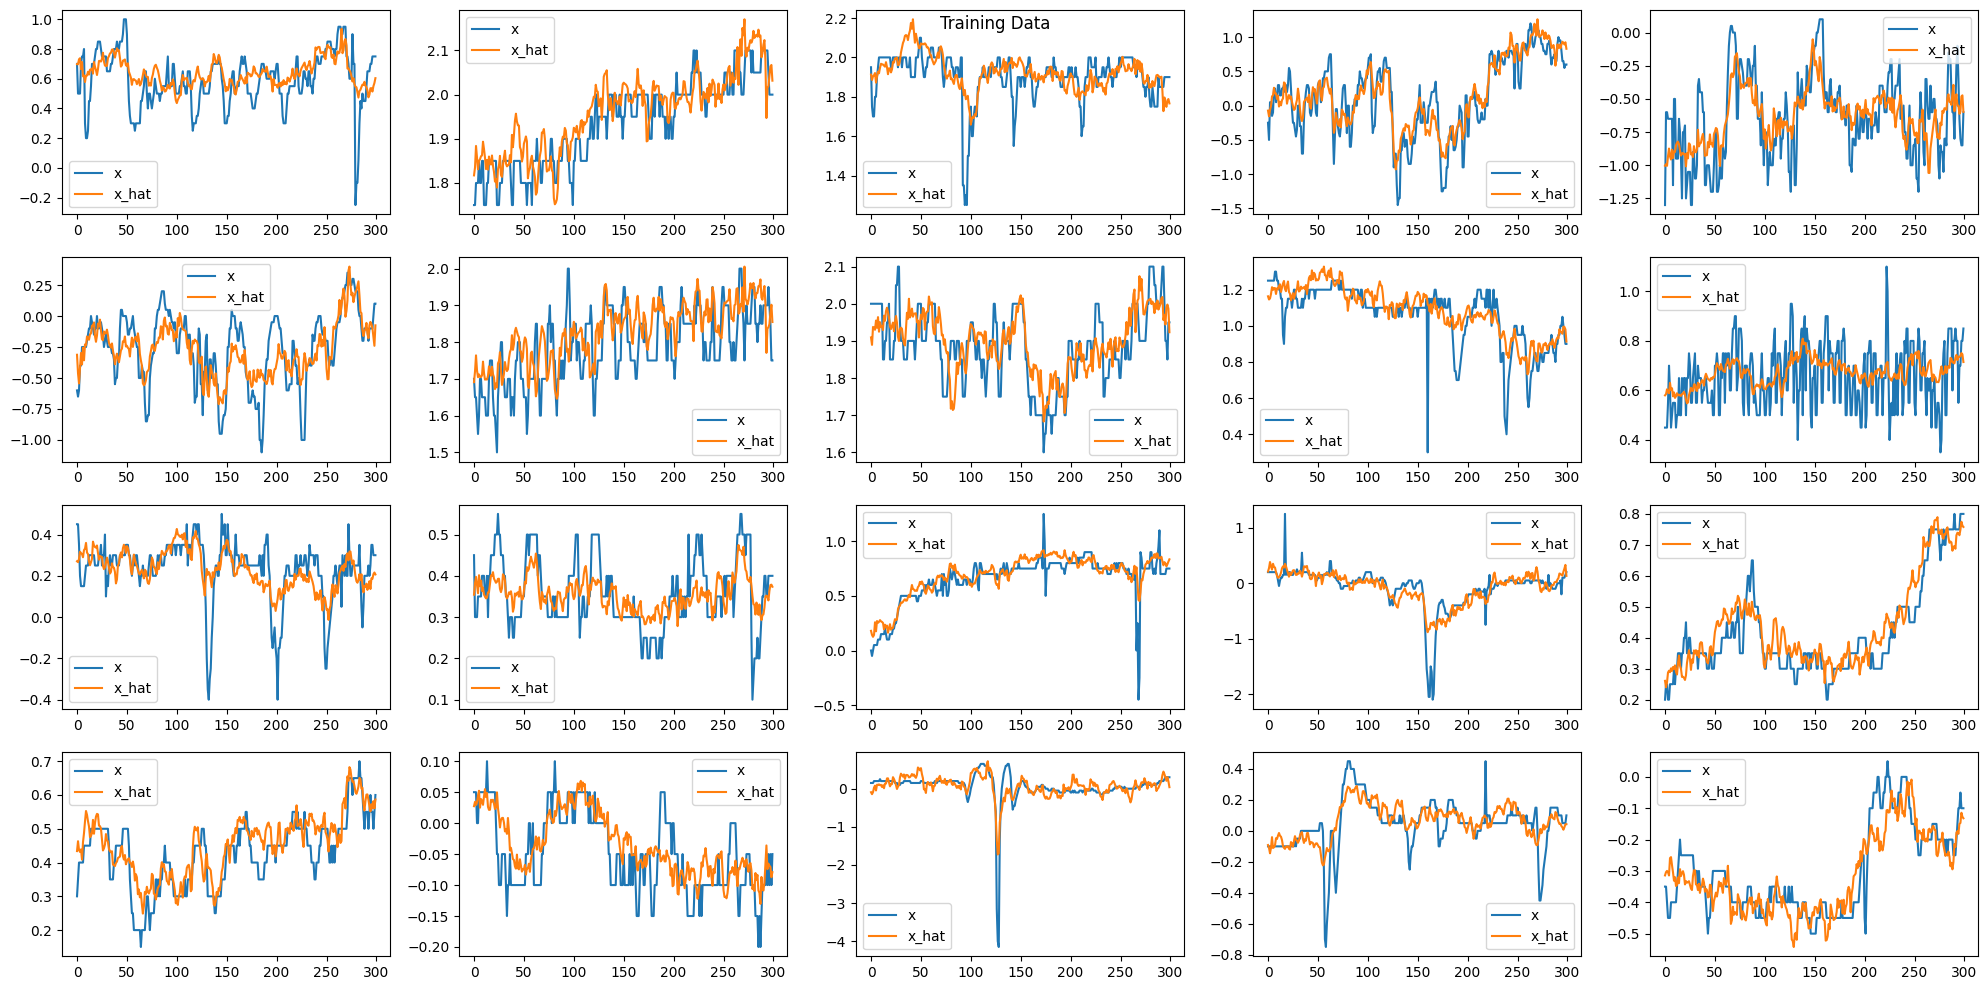

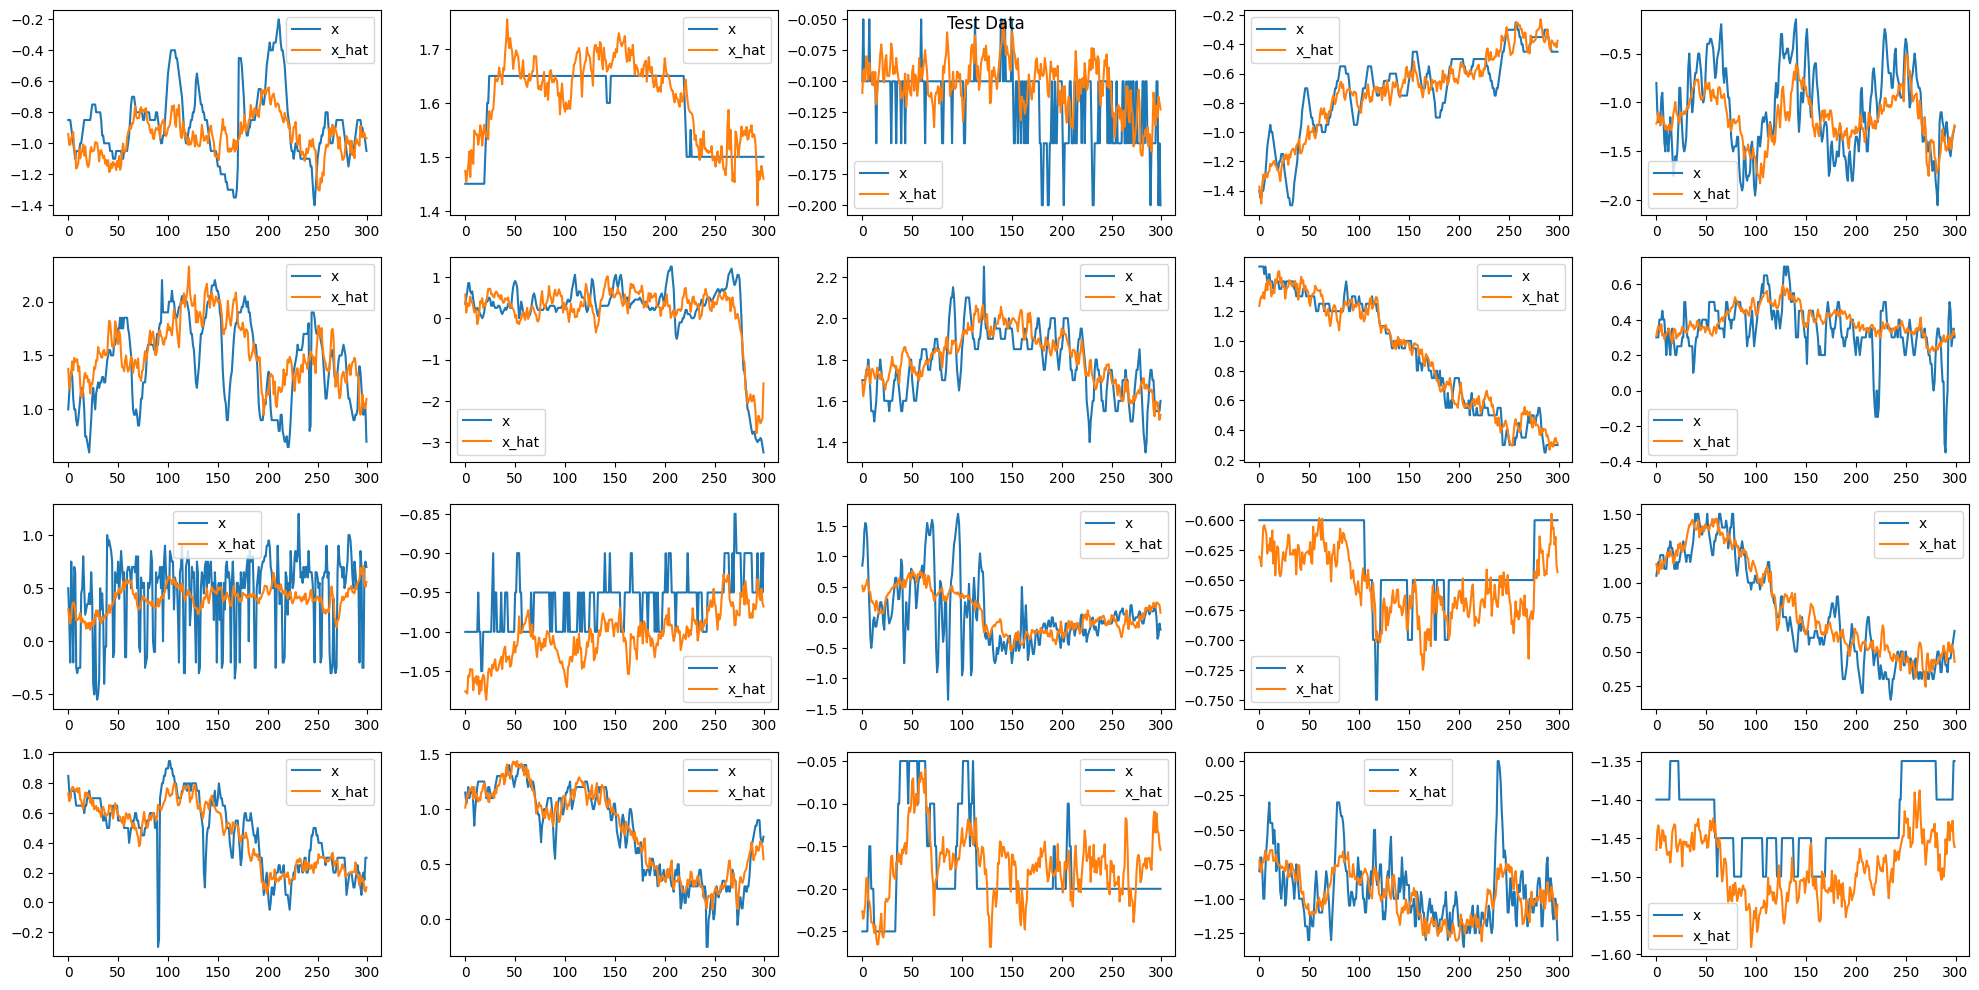

In [8]:
model.eval()
b = 0
fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(b, b+20):
    x, text_features, _ = train_dataloader.dataset[i]  # Assuming third element is labels
    x = x.unsqueeze(0).to(model.device)  # [1, ts_dim]
    text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]  # [1, text_dim]
            
    _, x_hat, mean, log_var = model(x, text_features)    
    axes[i//5, i%5].plot(x[0].cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat[0].cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()
fig.suptitle('Training Data')
plt.show()

fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(b, b+20):
    x, text_features, _ = test_dataloader.dataset[i]  # Assuming third element is labels
    x = x.unsqueeze(0).to(model.device)  # [1, ts_dim]
    text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]  # [1, text_dim]
    
    _, x_hat, mean, log_var = model(x, text_features)    
    axes[i//5, i%5].plot(x[0].cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat[0].cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()  
fig.suptitle('Test Data')
plt.show()


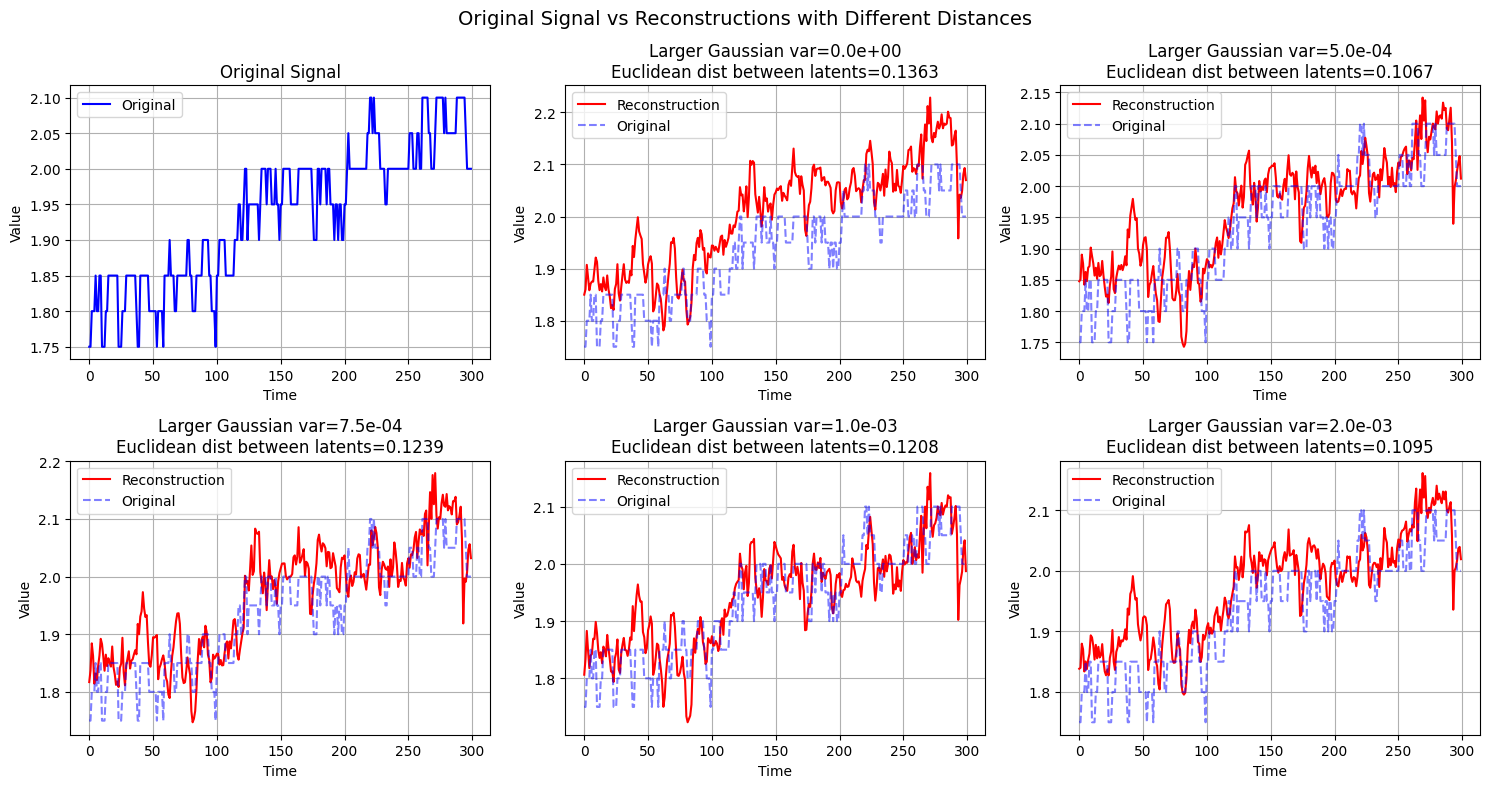

In [9]:
i = 1
x, text_features, _ = train_dataloader.dataset[i]  # Assuming third element is labels
# _, x_hat, mean, log_var = model(x, text_features)  

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Original Signal vs Reconstructions with Different Distances', fontsize=14)

# Flatten axs for easier iteration
axs = axs.flatten()

# Plot original signal in first subplot
axs[0].plot(x.cpu().detach().numpy(), 'b-', label='Original')
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].grid(True)
axs[0].legend()

# Plot reconstructions with different distances
distances = [0, 5e-4, 7.5e-4, 1e-3, 2e-3]
for i, distance in enumerate(distances, 1):
    # Get embeddings and reconstruction
    z_true, z_mean, z_log_var = model.ts_encoder(x) 
    z = model.ts_encoder.reparameterization(z_mean, z_log_var + distance)
    x_hat = model.ts_decoder(z)
    _, z_mean_hat, z_log_var_hat = model.ts_encoder(x_hat)

    # Calculate Euclidean distance
    z_mean = z_mean.cpu().detach().numpy()
    z_mean_hat = z_mean_hat.cpu().detach().numpy()
    euc_dist = np.sqrt(np.sum((z_mean - z_mean_hat) ** 2))

    # Plot reconstruction
    axs[i].plot(x_hat.cpu().detach().numpy(), 'r-', label=f'Reconstruction')
    axs[i].plot(x.cpu().detach().numpy(), 'b--', alpha=0.5, label='Original')
    axs[i].set_title(f'Larger Gaussian var={distance:.1e}\nEuclidean dist between latents={euc_dist:.4f}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].grid(True)
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Other ways to do VAE
- validate that under same training and data settings
- they should produce same result (train / test loss)

### VITAL + explicit loss

In [10]:
# # Initialize model and move to device
# # model = VAE_Linear_Medium(seq_len=300)
# import torch.optim as optim

# model = VITAL3D(
#                     ts_dim=ts_f_dim.shape[1],
#                     text_dim=tx_f_dim_ls[0].shape[1],
#                     n_text=len(tx_f_dim_ls),
#                     output_dim=config_dict['embedded_dim'],
#                     ts_encoder=ts_encoder,
#                     ts_decoder=ts_decoder
#                 )

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)


# # 1. Keep optimizer settings
# optimizer = optim.AdamW(
#     model.parameters(),
#     lr=1e-3,
#     weight_decay=1e-4
# )

# # 2. Modify scheduler for slower decay
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',
#     factor=0.9,          # More gentle reduction (was 0.8)
#     patience=100,        # Much more patience (was 50)
#     verbose=True,
#     min_lr=1e-6,        # Higher min_lr (was 1e-20)
#     threshold=1e-4,      # More sensitive to improvements
#     cooldown=20          # Add cooldown period after each reduction
# )

# def train_epoch(model, dataloader, optimizer, beta=0.01):  # Added beta parameter
#     model.train()
#     total_recon_loss = 0
#     total_kl_loss = 0
#     total_loss = 0
    
#     for batch_idx, (ts, text_features, labels) in enumerate(dataloader):
        
        
#         ts = ts.to(device)
#         if isinstance(text_features, list):
#             text_features = [t.to(device) for t in text_features]
#         else:
#             text_features = text_features.to(device)
#         labels = labels.to(device)

#         _, ts_hat, mean, log_var = model(ts, text_features)

#         # Modified loss computation
#         recon_loss = F.mse_loss(ts_hat, ts, reduction='sum') / ts.size(0)  # Per-sample loss
#         kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
        
#         # Use beta-VAE formulation
#         loss = recon_loss + beta * kl_loss  # Added beta weight
        
#         optimizer.zero_grad()
#         loss.backward(retain_graph=True)
#         # Add gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
        
#         total_recon_loss += recon_loss.item()
#         total_kl_loss += kl_loss.item()
#         total_loss += loss.item()
    
#     num_batches = len(dataloader)
#     return (total_loss / num_batches, 
#             total_recon_loss / num_batches, 
#             total_kl_loss / num_batches)

# # Training loop with beta annealing
# num_epochs = 10000
# beta_start = 0.0 # Start training with beta=0 (focus only on reconstruction)
# beta_end = 0 # End with beta=0.01 (final balance between reconstruction and KL)
# losses = []

# print("Starting training...")
# for epoch in range(num_epochs):
#     # Gradually increase beta
#     beta = min(beta_end, beta_start + (beta_end - beta_start) * epoch / 5000) # Gradually increase beta over 100 epochs (slowly introduce KL regularization)
    
#     # Train for one epoch
#     avg_loss, avg_recon, avg_kl = train_epoch(model, train_dataloader, optimizer, beta)
#     losses.append([avg_loss, avg_recon, avg_kl])
    
#     scheduler.step(avg_loss)
    
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}/{num_epochs}:')
#         print(f'  Loss: {avg_loss:.4f} (Recon: {avg_recon:.4f}, KL: {avg_kl:.4f})')
#         print(f'  Beta: {beta:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
#         # Add validation visualization
#         if epoch % 5000 == 0:
#             model.eval()
#             with torch.no_grad():
#                 x = next(iter(train_dataloader))[0][:5].to(device)
#                 text_features = next(iter(train_dataloader))[1][:5]#.to(device)
#                 text_features = [ttt.to(device) for ttt in text_features]
#                 _, x_hat, _, _ = model(x, text_features)
                
#                 plt.figure(figsize=(15, 3))
#                 for i in range(5):
#                     plt.subplot(1, 5, i+1)
#                     plt.plot(x[i].cpu(), label='Original')
#                     plt.plot(x_hat[i].cpu(), label='Reconstructed')
#                     plt.legend()
#                 plt.tight_layout()
#                 plt.show()

# # Plot losses
# losses = np.array(losses)
# plt.figure(figsize=(10, 5))
# plt.plot(losses[:, 0], label='Total Loss')
# plt.plot(losses[:, 1], label='Recon Loss')
# plt.plot(losses[:, 2], label='KL Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.yscale('log')  # Added log scale
# plt.show()


# # Loss of Variance/Detail: The reconstructed signals (orange) are much smoother than the original signals (blue), suggesting the VAE is learning to output averaged/mean values rather than capturing the true variability in the data. This is a common problem known as "posterior collapse" where the VAE produces overly smooth reconstructions.

### VITAL ts_encoder + ts_decoder

In [11]:
# # Initialize model and move to device
# # model = VAE_Linear_Medium(seq_len=300)
# import torch.optim as optim

# model = VITAL3D(
#                     ts_dim=ts_f_dim.shape[1],
#                     text_dim=tx_f_dim_ls[0].shape[1],
#                     n_text=len(tx_f_dim_ls),
#                     output_dim=config_dict['embedded_dim'],
#                     ts_encoder=ts_encoder,
#                     ts_decoder=ts_decoder
#                 )
# ts_encoder = model.ts_encoder
# ts_decoder = model.ts_decoder 

# # concate them in to one model
# class VAE_From_VITAL(nn.Module):
#     def __init__(self, ts_encoder, ts_decoder):
#         """Initialize VAE using existing encoder and decoder from VITAL
        
#         Args:
#             ts_encoder: Encoder from VITAL3D model
#             ts_decoder: Decoder from VITAL3D model
#         """
#         super(VAE_From_VITAL, self).__init__()
#         self.encoder = ts_encoder
#         self.decoder = ts_decoder
#         print(nn_summary(self))
        
#     def forward(self, x):
#         """Forward pass
        
#         Args:
#             x: Input tensor of shape [batch_size, seq_len]
            
#         Returns:
#             tuple:
#                 - x_hat: Reconstructed output
#                 - mean: Mean of latent distribution
#                 - log_var: Log variance of latent distribution
#         """
#         # Get latent representation using VITAL's encoder
#         z, mean, log_var = self.encoder(x)
        
#         # Decode using VITAL's decoder
#         x_hat = self.decoder(z)
        
#         return x_hat, mean, log_var

# # Usage:
# # Initialize the model using VITAL's encoder and decoder
# model = VAE_From_VITAL(ts_encoder, ts_decoder)
# model = model.to(device)

# # 1. Keep optimizer settings
# optimizer = optim.AdamW(
#     model.parameters(),
#     lr=1e-3,
#     weight_decay=1e-4
# )

# # 2. Modify scheduler for slower decay
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',
#     factor=0.9,          # More gentle reduction (was 0.8)
#     patience=100,        # Much more patience (was 50)
#     verbose=True,
#     min_lr=1e-6,        # Higher min_lr (was 1e-20)
#     threshold=1e-4,      # More sensitive to improvements
#     cooldown=20          # Add cooldown period after each reduction
# )
# def train_epoch(model, dataloader, optimizer, beta=0.01):  # Added beta parameter
#     model.train()
#     total_recon_loss = 0
#     total_kl_loss = 0
#     total_loss = 0
    
#     for batch_idx, (x, _, _) in enumerate(dataloader):
#         x = x.to(device)
#         x_hat, mean, log_var = model(x)
        
#         # Modified loss computation
#         recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)  # Per-sample loss
#         kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
        
#         # Use beta-VAE formulation
#         loss = recon_loss + beta * kl_loss  # Added beta weight
        
#         optimizer.zero_grad()
#         loss.backward()
#         # Add gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
        
#         total_recon_loss += recon_loss.item()
#         total_kl_loss += kl_loss.item()
#         total_loss += loss.item()
    
#     num_batches = len(dataloader)
#     return (total_loss / num_batches, 
#             total_recon_loss / num_batches, 
#             total_kl_loss / num_batches)


# def evaluate(model, dataloader, beta=0.01):
#     model.eval()
#     total_recon_loss = 0
#     total_kl_loss = 0
#     total_loss = 0
    
#     with torch.no_grad():
#         for batch_idx, (x, _, _) in enumerate(dataloader):
#             x = x.to(device)
#             x_hat, mean, log_var = model(x)
            
#             # Same loss computation as training
#             recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
#             kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
#             loss = recon_loss + beta * kl_loss
            
#             total_recon_loss += recon_loss.item()
#             total_kl_loss += kl_loss.item()
#             total_loss += loss.item()
    
#     num_batches = len(dataloader)
#     return (total_loss / num_batches, 
#             total_recon_loss / num_batches, 
#             total_kl_loss / num_batches)


# # Training loop with beta annealing
# num_epochs = 100000
# beta_start = 0.0 # Start training with beta=0 (focus only on reconstruction)
# beta_end = 0.1 # End with beta=0.01 (final balance between reconstruction and KL)
# losses = []

# print("Starting training...")
# for epoch in range(num_epochs):
#     # Gradually increase beta
#     beta = min(beta_end, beta_start + (beta_end - beta_start) * epoch / 5000) # Gradually increase beta over 100 epochs (slowly introduce KL regularization)
    
#     # Train for one epoch
#     train_loss, train_recon, train_kl = train_epoch(model, train_dataloader, optimizer, beta)
#     # Evaluate on test set
#     test_loss, test_recon, test_kl = evaluate(model, test_dataloader, beta)
    
#     train_losses.append([train_loss, train_recon, train_kl])
#     test_losses.append([test_loss, test_recon, test_kl])
    
#     # Use test loss for scheduler
#     scheduler.step(test_loss)
    
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}/{num_epochs}:')
#         print(f'  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})')
#         print(f'  Test Loss:  {test_loss:.4f} (Recon: {test_recon:.4f}, KL: {test_kl:.4f})')
#         print(f'  Beta: {beta:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
#         # Visualization every 5000 epochs
#         if epoch % 5000 == 0:
#             model.eval()
#             with torch.no_grad():
#                 # Train set reconstructions
#                 x_train = next(iter(train_dataloader))[0][:5].to(device)
#                 x_train_hat, _, _ = model(x_train)
                
#                 # Test set reconstructions
#                 x_test = next(iter(test_dataloader))[0][:5].to(device)
#                 x_test_hat, _, _ = model(x_test)
                
#                 plt.figure(figsize=(15, 6))
#                 # Train reconstructions
#                 plt.subplot(2, 1, 1)
#                 plt.title('Train Set Reconstructions')
#                 for i in range(5):
#                     plt.plot(x_train[i].cpu(), label=f'Original {i+1}')
#                     plt.plot(x_test_hat[i].cpu(), '--', label=f'Recon {i+1}')
#                 plt.legend()
                
#                 # Test reconstructions
#                 plt.subplot(2, 1, 2)
#                 plt.title('Test Set Reconstructions')
#                 for i in range(5):
#                     plt.plot(x_test[i].cpu(), label=f'Original {i+1}')
#                     plt.plot(x_test_hat[i].cpu(), '--', label=f'Recon {i+1}')
#                 plt.legend()
                
#                 plt.tight_layout()
#                 plt.show()


### VAE directly from one model object

In [12]:
# # Initialize model and move to device
# model = VAE_Linear_Medium(seq_len=300)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # 1. Better optimizer settings
# optimizer = optim.AdamW(  # Changed to AdamW
#     model.parameters(),
#     lr=5e-4,             # Lower initial learning rate
#     weight_decay=1e-4    # Add weight decay
# )

# # 2. Better scheduler settings
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',
#     factor=0.7,          # Gentler reduction
#     patience=20,         # More patience
#     verbose=True,
#     min_lr=1e-5,
#     threshold=1e-3       # Less stringent threshold
# )

# def train_epoch(model, dataloader, optimizer, beta=0.01):  # Added beta parameter
#     model.train()
#     total_recon_loss = 0
#     total_kl_loss = 0
#     total_loss = 0
    
#     for batch_idx, (x, _, _) in enumerate(dataloader):
#         x = x.to(device)
#         x_hat, mean, log_var = model(x)
        
#         # Modified loss computation
#         recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)  # Per-sample loss
#         kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
        
#         # Use beta-VAE formulation
#         loss = recon_loss + beta * kl_loss  # Added beta weight
        
#         optimizer.zero_grad()
#         loss.backward()
#         # Add gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()
        
#         total_recon_loss += recon_loss.item()
#         total_kl_loss += kl_loss.item()
#         total_loss += loss.item()
    
#     num_batches = len(dataloader)
#     return (total_loss / num_batches, 
#             total_recon_loss / num_batches, 
#             total_kl_loss / num_batches)


# def evaluate(model, dataloader, beta=0.01):
#     model.eval()
#     total_recon_loss = 0
#     total_kl_loss = 0
#     total_loss = 0
    
#     with torch.no_grad():
#         for batch_idx, (x, _, _) in enumerate(dataloader):
#             x = x.to(device)
#             x_hat, mean, log_var = model(x)
            
#             recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
#             kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()
#             loss = recon_loss + beta * kl_loss
            
#             total_recon_loss += recon_loss.item()
#             total_kl_loss += kl_loss.item()
#             total_loss += loss.item()
    
#     num_batches = len(dataloader)
#     return (total_loss / num_batches, 
#             total_recon_loss / num_batches, 
#             total_kl_loss / num_batches)


# # Training loop with beta annealing
# num_epochs = 100000
# beta_start = 0.0 # Start training with beta=0 (focus only on reconstruction)
# beta_end = 0.1 # End with beta=0.01 (final balance between reconstruction and KL)
# train_losses = []
# test_losses = []

# print("Starting training...")
# for epoch in range(num_epochs):
#     beta = min(beta_end, beta_start + (beta_end - beta_start) * epoch / 5000)
    
#     # Train and evaluate
#     train_loss, train_recon, train_kl = train_epoch(model, train_dataloader, optimizer, beta)
#     test_loss, test_recon, test_kl = evaluate(model, test_dataloader, beta)
    
#     # Store losses
#     train_losses.append([train_loss, train_recon, train_kl])
#     test_losses.append([test_loss, test_recon, test_kl])
    
#     # Use test loss for scheduler
#     scheduler.step(test_loss)
    
#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}/{num_epochs}:')
#         print(f'  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})')
#         print(f'  Test Loss:  {test_loss:.4f} (Recon: {test_recon:.4f}, KL: {test_kl:.4f})')
#         print(f'  Beta: {beta:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
#         if epoch % 5000 == 0:
#             model.eval()
#             with torch.no_grad():
#                 # Train reconstructions
#                 x_train = next(iter(train_dataloader))[0][:5].to(device)
#                 x_train_hat, _, _ = model(x_train)
                
#                 # Test reconstructions
#                 x_test = next(iter(test_dataloader))[0][:5].to(device)
#                 x_test_hat, _, _ = model(x_test)
                
#                 # Visualize both train and test reconstructions
#                 plt.figure(figsize=(15, 6))
                
#                 # Train reconstructions
#                 plt.subplot(2, 1, 1)
#                 plt.title('Train Set Reconstructions')
#                 for i in range(5):
#                     plt.plot(x_train[i].cpu(), label=f'Original {i+1}')
#                     plt.plot(x_train_hat[i].cpu(), '--', label=f'Recon {i+1}')
#                 plt.legend()
                
#                 # Test reconstructions
#                 plt.subplot(2, 1, 2)
#                 plt.title('Test Set Reconstructions')
#                 for i in range(5):
#                     plt.plot(x_test[i].cpu(), label=f'Original {i+1}')
#                     plt.plot(x_test_hat[i].cpu(), '--', label=f'Recon {i+1}')
#                 plt.legend()
                
#                 plt.tight_layout()
#                 plt.show()

# # Plot train vs test losses
# train_losses = np.array(train_losses)
# test_losses = np.array(test_losses)

# plt.figure(figsize=(15, 5))

# # Total Loss
# plt.subplot(1, 3, 1)
# plt.title('Total Loss')
# plt.plot(train_losses[:, 0], label='Train')
# plt.plot(test_losses[:, 0], label='Test')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.yscale('log')

# # Reconstruction Loss
# plt.subplot(1, 3, 2)
# plt.title('Reconstruction Loss')
# plt.plot(train_losses[:, 1], label='Train')
# plt.plot(test_losses[:, 1], label='Test')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.yscale('log')

# # KL Loss
# plt.subplot(1, 3, 3)
# plt.title('KL Loss')
# plt.plot(train_losses[:, 2], label='Train')
# plt.plot(test_losses[:, 2], label='Test')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.yscale('log')

# plt.tight_layout()
# plt.show()
